# Extract the activeobjects list

### Helper functions for talking to BigPEmu in debug mode

In [32]:
import bigpemu_debug as bigp
import struct

"""
Code starts 0x00192000
"""
locations = {
    # The address to start at
    # The number of bytes to fetch
    "ddlist":     (0xEF9A,8),
    "activeobjects":     (0x847C,8),
}

def send_hex_dump_cmd_raw(from_addr,dump_len,responses=1):
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\xff\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,responses)
    return response[0][2][24:] # Snip header

def send_hex_dump_cmd(location):
    from_addr,dump_len = locations[location]
    from_addr = struct.pack('<I', from_addr)
    dump_len = struct.pack('<H', dump_len)

    hex_dump = \
    b"\x0c\x00\x00\x00\x10\x00\x00\x00\xff\x00\x00\x00\x00\x00\x00\x00" \
    + from_addr + b"\x00\x00\x00\x00" + dump_len + b"\x00\x00\x00\x00\x00\x00"

    s.sendall(hex_dump)
    response = bigp.get_response(s,1)
    return response[0][2][24:] # Snip header

def dump_standard(hex_dump,WIDTH=32):
    mem = '\n'.join([
        ','.join(['{:02X}'.format(x) for x in hex_dump[l:l+WIDTH]]) 
        for l in range(0,len(hex_dump),WIDTH)
    ])
    return mem



## Launch BigPEmu and connect to the debug server

Get BigPEmu.

In [ ]:
!wget https://www.richwhitehouse.com/jaguar/builds/BigPEmu_v118-DEV.zip
!unzip -d BigPEmu_v118-DEV BigPEmu_v118-DEV.zip

Run Tempest 2000 using BigPEmu.

In [224]:
import socket
import os
import time

# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../tempest2k/t2000.abs &")
time.sleep(5)

HOST = "127.0.0.1"  # The server's hostname or IP address
PORT = 44123  # The port used by the server

# Connect to the debug server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((HOST, PORT))


## Get the activeobject list and the object list

### Helper functions and data structure for the object list

In [225]:
import cry_rgb as cry
from PIL import Image, ImageColor
import numpy as np
import matplotlib.pyplot as plt


obj_names = [
    "Bit Mapped Object",
    "Scaled Bit Mapped Object",
    "Graphics Processor Object",
    "Branch Object",
    "Stop Object",
    "Unused",
    "Unused",
    "Unused RAM",
]

obj_defs = {
    0: [ # Bit Mapped Object
            [ # First Phrase
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,23,"HEIGHT"),
                (24,42,"LINK"),
                (43,63,"DATA"),
            ],
            [ # Second Phrase
                (0,11,"XPOS"),
                (12,14,"DEPTH"),
                (15,17,"PITCH"),
                (18,27,"DWIDTH"),
                (28,37,"IWIDTH"),
                (38,44,"INDEX"),
                (45,45,"REFLECT"),
                (46,46,"RMW"),
                (47,47,"TRANS"),
                (48,48,"RELEASE"),
                (49,54,"FIRSTPIX"),
            ],
    ],
    1: [ #Scaled Bit Mapped Object
            [ # First Phrase
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,23,"HEIGHT"),
                (24,42,"LINK"),
                (43,63,"DATA"),
            ],
            [ # Second Phrase
                (0,11,"XPOS"),
                (12,14,"DEPTH"),
                (15,17,"PITCH"),
                (18,27,"DWIDTH"),
                (28,37,"IWIDTH"),
                (38,44,"INDEX"),
                (45,45,"REFLECT"),
                (46,46,"RMW"),
                (47,47,"TRANS"),
                (48,48,"RELEASE"),
                (49,54,"FIRSTPIX"),
            ],
            [ # Third Phrase
                (0,7, "HSCALE"),
                (8,15,"VSCALE"),
                (16,23,"REMAINDER"),
            ],
    ],
    2: [ # Graphics Processor Object
            [
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,63,"DATA"),
            ],
    ],
    3: [ # Branch Object
            [
                (0,2,"Type"),
                (3,13,"YPOS"),
                (14,15,"CC"),
                (16,23,"Unused"),
                (24,42,"LINK"),
            ],
    ],
    4: [ # Stop Object
            [
                (0,2,"Type"),
                (3,63,"DATA"),
            ],
    ],
    7: [ # Unused RAM
            [
                (0,2,"Type"),
                (3,63,"Unused RAM"),
            ],
    ],
}

# Extract the bits for each entry in the object.
get_bits = lambda o,start,end: (o >> start) & int('1' * ((end-start)+1),base=2)
def get_type(o): return get_bits(o,0,2)

def getPixels(cry_pixels,width=2):
    rgb_pixels = []
    for i in range(0, len(cry_pixels),2):
        t = cry_pixels[i:i+2]
        #print(i,t,int.from_bytes(t,'little'))
        rgb = cry.cry_to_rgb(int.from_bytes(t,'big'))
        rgb_pixels += [rgb]
    pad_len = width - (len(rgb_pixels) % width)
    rgb_pixels += [(0,0,0)] * pad_len # Pad to our chosen width
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels

def get1BitPixels(cry_pixels,width=2):
    rgb_pixels = []
    for b in cry_pixels:
        for m in [128,64,32,16,8,4,2,1]:
            rgb_pixels += [(255,255,255) if (b & m) else (0,0,0)]
    pad_len = width - (len(rgb_pixels) % width)
    rgb_pixels += [(0,0,0)] * pad_len
    pixels = np.array(rgb_pixels).astype(np.uint8)
    pixels.shape = (-1,width,3)
    return pixels


###  Helper functions and data structure for the activeobject list

In [318]:
run_vex = [
    "rrts","player_shot","run_flipper","run_zap","kill_shot","run_tanker",
    "run_spike","run_spiker","run_ashot","run_fuseball","blowaway",
    "run_pulsar","oblow","go_downc","go_downf","claw_con2","claw_con1",
    "rez_claw","czoom1","czoom2","pzap","rundroid",
    "run_pixex","run_pspark","run_prex","run_pup","xshot","run_gate",
    "xr_pixex","run_fw","run_h2hclaw","run_mirr","run_h2hshot","run_h2hgen",
    "run_h2hball","oblow2","rumirr","refsht","refsht2","run_adroid","loiter"
]
def get_run_vex(x):
    i = int.from_bytes(x, byteorder='big', signed=False)
    if i > len(run_vex):
        return x.hex()
    return run_vex[i]

def get_object_type(x):
    o_type = get_run_vex(x)
    if o_type in active_object_definitions:
        return o_type
    return "default"

draw_vex = [
    "rrts","draw","draw_z","draw_vxc","draw_spike","draw_pixex","draw_mpixex",
    "draw_oneup","draw_pel","changex",
    "draw_pring","draw_prex","dxshot","drawsphere","draw_fw","dmpix","dsclaw","dsclaw2"
]
def get_draw_vex(x):
    i = int.from_bytes(x, byteorder='big', signed=False)
    if i > len(draw_vex):
        return x.hex()
    return draw_vex[i]

solids = [
    "rrts","cdraw_sflipper","draw_sfliptank","s_shot","draw_sfuseball",
    "draw_spulsar","draw_sfusetank","ringbull","draw_spulstank",
    "draw_pixex","draw_pup1","draw_gate","draw_h2hclaw","draw_mirr",
    "draw_h2hshot","draw_h2hgen","dxshot",
    "draw_pprex","draw_h2hball","draw_blueflip","ringbull","supf1",
    "supf2","draw_beast","dr_beast3","dr_beast2","draw_adroid"
]
def get_draw_routine(x):
    index = int.from_bytes(x,byteorder='big',signed=True)
    if index < 0:
        # It's an index into 'solids'
        return solids[abs(index)]
    # It's the address of a vector object.
    return x.hex()

def int_word(x):
    # Swap the words in a long and return as a base 10 int.
    x = int.from_bytes(x, byteorder='big', signed=True)
    return x

def swap_words_int(x):
    # Swap the words in a long and return as a base 10 int.
    x = int.from_bytes(x, byteorder='big', signed=False)
    return (((x << 16) & 0xFFFF0000) |
            ((x >> 16) & 0x0000FFFF))   

rail_type = [
    "climb rail",
    "cross rail",
    "blowaway"
]

enemy_type = [
    "not an enemy",
    "enemy",
]
def get_enemy_type(x):
    i = int.from_bytes(x, byteorder='big', signed=False)
    if i > len(enemy_type):
        return x.hex()
    return enemy_type[i]

active_object_definitions = {
    "default" :
    [ # First Phrase
        (0,3  ,"Index into draw routine in 'solids'.", get_draw_routine),
        (4,5  ,"X", int_word), # Only the first word is used.
        (8,9 ,"Y", int_word), # Only the first word is used.
        (12,13,"Z", int_word), # Only the first word is used.
        (16,17,"Position/lane on web.", int_word), # Only the first word is used.
        (20,21,"Velocity", int_word), # Only the first word is used.
        (24,27,"Acceleration/Flipper Mode", None),
        (28,29,"XZ Orientation  (Roll)", int_word),
        (30,31,"Y Rotation  (Pitch)", int_word),
        (32,33,"Z Rotation  (Yaw)", int_word),
        (34,35,"Draw Type (Index into draw routine in draw_vex)",get_draw_vex),
        (36,39,"Start address of pixel data.", None),
        (40,41,"Colour", None),
        (42,43,"Scale factor", None),
        (44,45,"0 = climb rail, 1 = cross rail, 2 = blowaway", None),
        (46,49,"Size of Pixel Data", None),
        (50,51,"Marked for deletion", None),
        (52,53,"Enemy or Not", get_enemy_type),
        (54,55,"Object Type  (Index into update routine in run_vex).", get_run_vex),
        (56,59,"Address of Previous Object", None),
        (60,63,"Address of Next Object", None),
    ],
    "player_shot" :
    [ # First Phrase
        (0,3  ,"Draw Routine.", get_draw_routine),
        (4,5  ,"X", int_word), # Only the first word is used.
        (8,9 ,"Y", int_word), # Only the first word is used.
        (12,13,"Z", int_word), # Only the first word is used.
        (16,17,"Web Lane", int_word), # Only the first word is used.
        (20,21,"Velocity", int_word), # Only the first word is used.
        (24,27,"Acceleration", None),
        (28,29,"Roll", int_word),
        (30,31,"Pitch", int_word),
        (32,33,"Yaw", int_word),
        (34,35,"draw_vex routine",get_draw_vex),
        (36,39,"Y/X in Sprite Sheet", None),
        (40,41,"Colour", None),
        (42,43,"Scale factor", None),
        (44,45,"0 = climb rail, 1 = cross rail, 2 = blowaway", None),
        (46,49,"Width/Height in Sprite Sheet", None),
        (50,51,"Marked for deletion", None),
        (52,53,"Enemy or Not", get_enemy_type),
        (54,55,"run_vex routine", get_run_vex),
        (56,59,"Address of Previous Object", None),
        (60,63,"Address of Next Object", None),
    ],
    "run_ashot" :
    [ # First Phrase
        (0,3  ,"Draw Routine.", get_draw_routine),
        (4,5  ,"X", int_word), # Only the first word is used.
        (8,9 ,"Y", int_word), # Only the first word is used.
        (12,13,"Z", int_word), # Only the first word is used.
        (16,17,"Web Lane", int_word), # Only the first word is used.
        (20,21,"Velocity", int_word), # Only the first word is used.
        (24,27,"Acceleration", None),
        (28,29,"Roll", int_word),
        (30,31,"Pitch", int_word),
        (32,33,"Yaw", int_word),
        (34,35,"draw_vex routine",get_draw_vex),
        (36,39,"Y/X in Sprite Sheet", None),
        (40,41,"Colour", None),
        (42,43,"Scale factor", None),
        (44,45,"0 = climb rail, 1 = cross rail, 2 = blowaway", None),
        (46,49,"Width/Height in Sprite Sheet", None),
        (50,51,"Marked for deletion", None),
        (52,53,"Enemy or Not", get_enemy_type),
        (54,55,"run_vex routine", get_run_vex),
        (56,59,"Address of Previous Object", None),
        (60,63,"Address of Next Object", None),
    ],
}


In [327]:
# Launch bigpemu and wait a moment.
os.system("wine ./BigPEmu_v118-DEV/BigPEmuDev.exe ../tempest2k/t2000.abs &")
time.sleep(5)
# Connect to the debug server
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect((HOST, PORT))


### Get the current activeobjects list and the current object list. 

In [347]:
#
# First we get the activeobjects list.
#
NUM_OBJECTS = 32
OBJECT_LENGTH = 64
# Get the address of the activeobjects list.
ao_addr_raw = send_hex_dump_cmd("activeobjects")
ao_addr = int.from_bytes(ao_addr_raw[:4], byteorder='big', signed=False)
# Now get the list itself.
active_object_data = send_hex_dump_cmd_raw(ao_addr,NUM_OBJECTS*OBJECT_LENGTH)
#print(active_object_data)

#
# Next we get the object list. We do this because we want a shot of the 
# screen data relevant to our activeobjects list, so we can compare the
# list with what we see on screen.
#
# 1. Get the address of the object list.
hex_dump = send_hex_dump_cmd("ddlist")
dd_addr = int.from_bytes(hex_dump[:4], byteorder='big', signed=False)
print(hex(dd_addr))

# 2. Get the raw data of the object list.
hex_dump = send_hex_dump_cmd_raw(dd_addr,424)
obj_list_raw = dump_standard(hex_dump,WIDTH=8)
obj_list = obj_list_raw.split("\n")[1:-1]

# 3. Parse out the object list entries.
i = 0
obj_list_data = []
while True:
    if i >= len(obj_list):
        break
    o = int(obj_list[i].replace(',',''),16)
    o_type = get_type(o)
    if o_type == 7:
        break
    assert(o_type in obj_defs)
    o_vals_print = []
    obj_data = {}
    print(obj_names[o_type])
    for o_map in obj_defs[o_type]:
        o = int(obj_list[i].replace(',',''),16)
        for start,end,description in o_map:
            o_val = get_bits(o,start,end)
            if description in ["DATA","LINK"]:
                o_val = hex(o_val << 3)
            o_vals_print += [f"{description}: {o_val}"]
            obj_data[description] = o_val
        i+=1
    obj_list_data += [obj_data]
    print('    ' + '\n    '.join(o_vals_print))

# 4. Add the contents of the screen data to each object
#    so we can work with it without the debugger running.
for o in obj_list_data:
    if "DWIDTH" not in o:
        continue
    data = bytearray()
    data_len = (o["DWIDTH"] * 8) * o["HEIGHT"]
    data_adr = int(o["DATA"],16)
    while len(data) < data_len:
        data += send_hex_dump_cmd_raw(data_adr,0xF000)
        data_adr += 0xF000
    data = data[:data_len]
    o["DATA_BYTES"] = data


0xeb40
Branch Object
    Type: 3
    YPOS: 507
    CC: 2
    Unused: 0
    LINK: 0xeb20
Bit Mapped Object
    Type: 0
    YPOS: 44
    HEIGHT: 279
    LINK: 0xeb70
    DATA: 0x100000
    XPOS: 4088
    DEPTH: 4
    PITCH: 1
    DWIDTH: 96
    IWIDTH: 96
    INDEX: 0
    REFLECT: 0
    RMW: 0
    TRANS: 1
    RELEASE: 0
    FIRSTPIX: 0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Bit Mapped Object
    Type: 0
    YPOS: 60
    HEIGHT: 48
    LINK: 0xeb90
    DATA: 0x50000
    XPOS: 4088
    DEPTH: 4
    PITCH: 1
    DWIDTH: 96
    IWIDTH: 96
    INDEX: 0
    REFLECT: 0
    RMW: 0
    TRANS: 1
    RELEASE: 0
    FIRSTPIX: 0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x0
Stop Object
    Type: 4
    DATA: 0x

####  Now that we have retrieved our data from bigpemu, we can play with it at our leisure. 

In [348]:
def lookup_value(lookup, o_val):
    if not lookup:
        return o_val.hex()
    return lookup(o_val)

def get_object_values(o_data, object_def):
    o_vals_list = []
    for start,end,description, lookup in object_def:
        o_val = o_data[start:end+1]
        lookup_val = lookup_value(lookup, o_val)
        o_vals_list += [(description, o_val.hex(), lookup_val)]
    o_vals_list += [("Current Address", hex(curr_address), hex(curr_address))]
    return o_vals_list

curr_address = int.from_bytes(ao_addr_raw[:4], byteorder='big', signed=False)
active_objects = []
for ao_index in range(0, NUM_OBJECTS*OBJECT_LENGTH, OBJECT_LENGTH):
    o_data = active_object_data[ao_index:ao_index+OBJECT_LENGTH]
    o_type_index = o_data[54:56]
    o_type = get_object_type(o_type_index)
    object_def = active_object_definitions[o_type]
    o_vals_list = get_object_values(o_data, object_def)
    curr_address += OBJECT_LENGTH
    active_objects +=[o_vals_list]
print_objects = [ao for ao in active_objects if ao[0][2] != "00000000"]
[ao[0] for ao in active_objects if ao[0][2] != "00000000"]

[("Index into draw routine in 'solids'.", 'ffffffff', 'cdraw_sflipper'),
 ("Index into draw routine in 'solids'.", 'ffffffff', 'cdraw_sflipper'),
 ('Draw Routine.', 'fffffffd', 's_shot'),
 ('Draw Routine.', 'fffffff7', 'draw_pixex'),
 ('Draw Routine.', 'fffffff7', 'draw_pixex'),
 ('Draw Routine.', 'fffffff7', 'draw_pixex'),
 ('Draw Routine.', 'fffffff7', 'draw_pixex'),
 ('Draw Routine.', 'fffffff7', 'draw_pixex')]

In [326]:
header = """        \\toprule
        Enemy Bullet & Object Data \\\\
        \\midrule
        \\makecell[l]{
            \\includegraphics[width=2.2cm]{activeobjects/chevron.png} \\\\
        }
        &
        \\makecell[l]{
          \\begingroup
          \\renewcommand{\\arraystretch}{.8} % Default value: 1
          \\begin{tabular}[t]{ll}"""

footer = """          \\end{tabular}
          \\endgroup
        }
        \\\\"""

for po in print_objects:
    print(header)
    for (lname,_,lval), (rname,_,rval) in zip(po[:11],po[11:]):
        ln = f"\\tcode{{{lname}: {lval}}}   &    \\tcode{{{rname}: {rval}}}  \\\\"
        ln = ln.replace('_','\_')
        print(ln)
    print(footer)


        \toprule
        Enemy Bullet & Object Data \\
        \midrule
        \makecell[l]{
            \includegraphics[width=2.2cm]{activeobjects/chevron.png} \\
        }
        &
        \makecell[l]{
          \begingroup
          \renewcommand{\arraystretch}{.8} % Default value: 1
          \begin{tabular}[t]{ll}
\tcode{Draw Routine.: s\_shot}   &    \tcode{Y/X in Sprite Sheet: 00b6000a}  \\
\tcode{X: -12}   &    \tcode{Colour: 0018}  \\
\tcode{Y: -26}   &    \tcode{Scale factor: 0000}  \\
\tcode{Z: 100}   &    \tcode{0 = climb rail, 1 = cross rail, 2 = blowaway: 0000}  \\
\tcode{Web Lane: 0}   &    \tcode{Width/Height in Sprite Sheet: 00070007}  \\
\tcode{Velocity: 0}   &    \tcode{Marked for deletion: 0000}  \\
\tcode{Acceleration: 0000ca82}   &    \tcode{Enemy or Not: enemy}  \\
\tcode{Roll: 124}   &    \tcode{run\_vex routine: run\_ashot}  \\
\tcode{Pitch: 0}   &    \tcode{Address of Previous Object: ffffffff}  \\
\tcode{Yaw: 0}   &    \tcode{Address of Next Object: 0000d

####  Let's display the screens from the time the activeobjects list was retrieved

384 279 214272
384 48 36864


<Figure size 504x504 with 0 Axes>

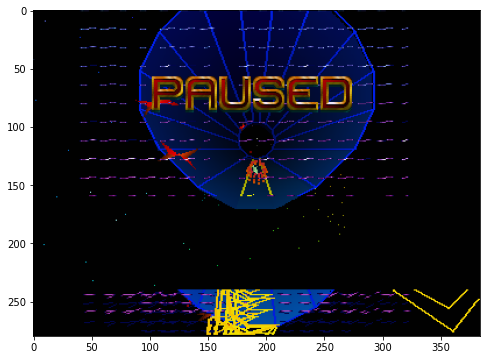

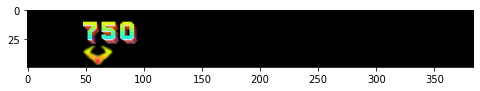

In [344]:
SCALE = 1
pixels_for_depth = [get1BitPixels,get1BitPixels,get1BitPixels,get1BitPixels,
                    getPixels,getPixels]

fig = plt.figure(figsize=(7,7))

def clip_data(data, data_width, clip_width, data_len):
    clipped_data = bytearray()
    for i in range(0,len(data), data_width):
        clipped_data += data[i:i+clip_width]
        if len(clipped_data) > data_len:
            break
    return clipped_data

for i, o in enumerate(obj_list_data):
    if o["Type"] < 2:
        clip_width = o["IWIDTH"] * 8
        data_width = o["DWIDTH"] * 8
        image_height = o["HEIGHT"] 
        image_width = o["IWIDTH"] * 4
        if not image_width:
            continue
        data_len = (image_width * 2) * image_height
        print(image_width, image_height, data_len)
        data = o["DATA_BYTES"]
        data = clip_data(data, data_width, clip_width, data_len)
        
        get_pixels = pixels_for_depth[o["DEPTH"]]
        pixels = get_pixels(data,image_width)
        
        img = Image.fromarray(pixels,mode='RGB')
        img = img.resize((img.width * SCALE, img.height * SCALE), Image.NEAREST)
        img.save(f"activeobjects/data_{i}_raw.png")
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        plt.savefig(f"activeobjects/data_{i}.png", transparent=True,bbox_inches='tight')
        continue



# Rough Work

In [72]:
active_object_pixels = []
for ao in active_objects:
    start_address = int(ao[11][1],16)
    data_len = min(0xffff,int(ao[15][1],16))
    print(start_address,data_len)
    pixel_data = get_pixel_data(start_address,data_len)
    active_object_pixels += [pixel_data]
active_object_pixels[0]

bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

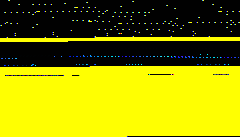

In [76]:
SCALE = 1
data =active_object_pixels[9]
pixels = getPixels(data,240)
img = Image.fromarray(pixels,mode='RGB')
img = img.resize((img.width * SCALE, img.height * SCALE), Image.NEAREST)
img

In [81]:
hex(0xfff - 4088)

'0x7'